#TIME SERIES ANALYSIS

#Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

##DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


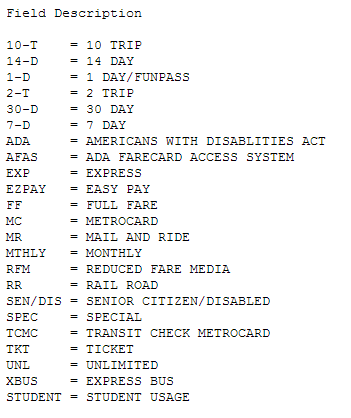

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

##note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

#Task 1: 
##Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
##Identify it and figure out what it is due to.


#Task 2: 
##Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


#Task 3:
##Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


#EXTRA CREDIT: Cluster. 
##Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
##Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

##i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

##removing empty light curves
tots = tots[tots.std(1)>0]

##with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

##and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

##then you can run:

km.fit(vals)

#HINTS: 

##When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


#Possibly useful functions

##I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
##(But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)



In [343]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [373]:
#Task 1

In [374]:
mta = np.load("MTA_Fare.npy").astype(float)

In [375]:
mta.shape

(600, 23, 194)

In [376]:
#after reading the datacube you should see:
mta.shape


(600, 23, 194)

In [377]:
mta[mta == (-1)] = float('NaN')

In [378]:
len(np.nanmean(mta,axis=(0,1)))

194

In [379]:
weekmeans = pd.DataFrame(np.nanmean(mta,axis=(0,1)))

In [380]:
weekmeans.columns = ['means']

In [381]:
weekmeans['zscore']=abs((weekmeans['means'].mean()-weekmeans['means'])/weekmeans['means'].std())

In [382]:
weekmeans.sort(['zscore'],ascending=False)[0:1]

,means,zscore
126,493.259546,8.725996


In [383]:
pd.DataFrame(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/07/2014'),freq='W'))[126:127]

,0
126,2012-10-21


In [384]:
#The odd week is October 21 to 27, 2012. This is Hurricane Sandy.

ride types list

In [385]:
#Task 2

In [386]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [387]:
weeks_by_type = pd.DataFrame(np.nanmean(mta,axis=0))

In [388]:
weeks_by_type.index = ridetype

In [389]:
weeks_by_type['avgfirst10'] = (weeks_by_type[range(0,10)].T.mean())
weeks_by_type['avglast10'] = (weeks_by_type[range(184,194)].T.mean())
weeks_by_type['ratio'] = weeks_by_type['avglast10']/weeks_by_type['avgfirst10']

In [390]:
weeks_by_type['ratio']

10t          1.023192
14d          1.253723
1d           1.112833
2t           0.935036
30d          1.035008
7d           1.391607
ada          0.901034
afas         0.000210
exp          0.000011
ez           0.000002
ff           0.819930
mc           1.215190
mr       24832.489860
month        0.579508
rfm          0.650466
rr           2.596518
sen          2.913348
spec        70.308565
tcmc         1.534239
t            1.022872
umlim        0.810115
xbus         1.664684
stud              NaN
Name: ratio, dtype: float64

In [391]:
ex = pd.DataFrame(weeks_by_type.loc['10t'][0:194])

In [392]:
ex['week'] = ex.index
ex['dat'] = ex['10t']
ex['num'] = ex['week'].apply(float)

In [393]:
model = smf.ols(formula = 'dat ~ num',data=ex).fit()

In [394]:
model.rsquared

0.042836367922000962

In [395]:
for i in weeks_by_type.index:
    ex = pd.DataFrame(weeks_by_type.loc[i][0:194])
    ex['week'] = ex.index
    ex['dat'] = ex[i]
    ex['num'] = ex['week'].apply(float)
    model = smf.ols(formula = 'dat ~ num',data=ex).fit()
    print i, model.rsquared

10t 0.042836367922
14d 0.42476228286
1d 0.0821606765432
2t 0.0059547758185
30d 0.0064395818125
7d 0.585986988544
ada 0.0092378145787
afas 0.441408116192
exp 0.411951496822
ez 0.419689748898
ff 0.0245557036946
mc 0.0677248469637
mr 0.578559314829
month 0.498264904534
rfm 0.144814631213
rr 0.79866166879
sen 0.822386525914
spec 0.481387793801
tcmc 0.51304409597
t 0.00662002433172
umlim 0.000641574479206
xbus 0.449260367445
stud 0.0185675457681


In [396]:
#14d, 7d, mr, month, rr, sen, tcmc have rsqaured > 0.5

In [397]:
#Increasing: 14d, 7d, mr, rr, sen, spec, tcmc, xbus
#Decreasing: month

In [398]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mta.shape)
mta_allsum = np.nansum(mta, axis=0)
print (mta_allsum.shape)
#or for all ride types
mta_allsum = np.nansum(mta, axis=1)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)


In [399]:
198.0/52

3.8076923076923075

In [400]:
periodicity = {}
for i in range(len(mta_allsum)):
#    fourier = np.abs(np.fft.rfft(mta_allsum[0]))
    periodicity[i] = np.abs(np.fft.rfft(mta_allsum[i])[4])
station_periodicity = sorted(periodicity.items())

In [401]:
sorted(station_periodicity,key= lambda x: x[1],reverse=True)[0:4]

[(0, 2980160.6355953491),
 (194, 2950388.929214194),
 (150, 2931895.8769513383),
 (327, 2402218.5809588572)]

In [402]:
a = pd.DataFrame(pd.date_range(pd.to_datetime('05/21/2010'), pd.to_datetime('02/07/2014'),freq='W'))[0].values

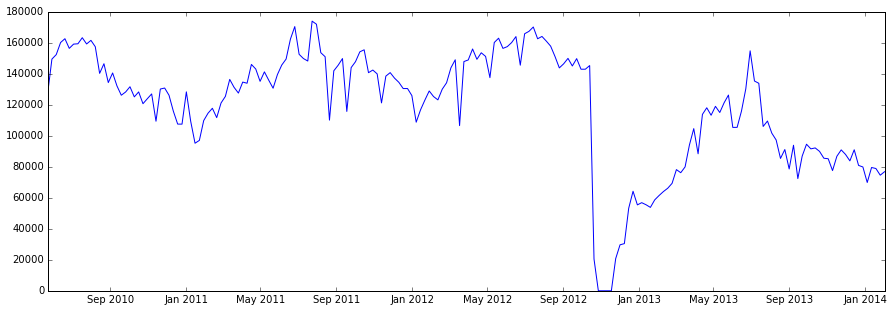

In [403]:
fig=plt.figure(figsize=(15,5))
plt.plot(a,mta_allsum[0])

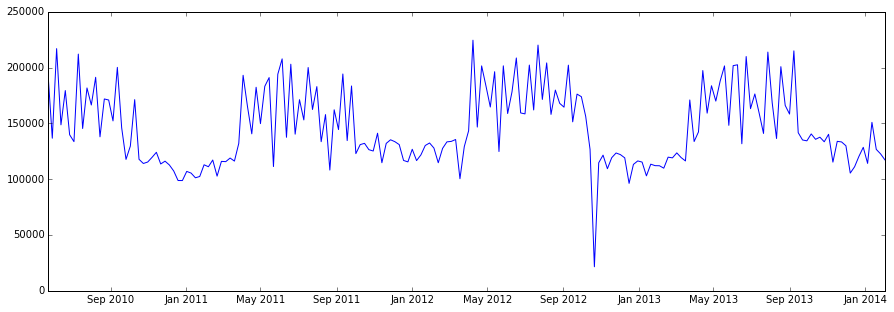

In [404]:
fig=plt.figure(figsize=(15,5))
plt.plot(a,mta_allsum[194])

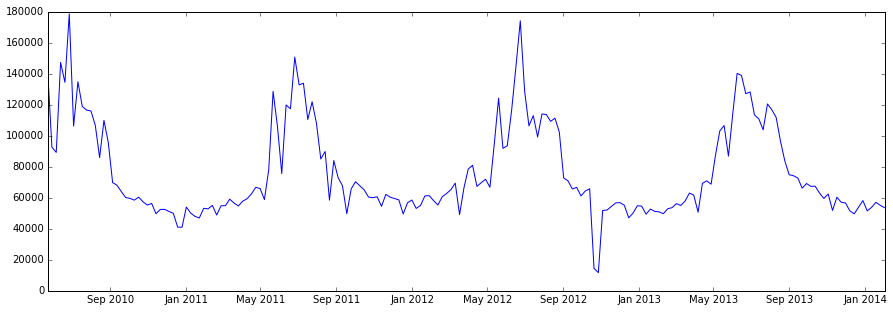

In [405]:
fig=plt.figure(figsize=(15,5))
plt.plot(a,mta_allsum[150])

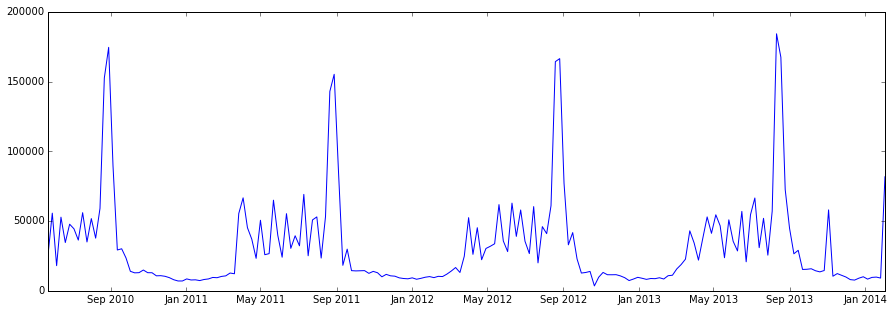

In [406]:
fig=plt.figure(figsize=(15,5))
plt.plot(a,mta_allsum[327])

In [407]:
#They all have spikes in the summer; maybe they're near parks or other tourist destinations.